# Phylogenic Tree

Some examples of tree data manipulation using methods that are called directly from a `pandas.DataFrame` object containing the history of the modelled population.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

#import phylopandas

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel

%matplotlib inline

## run ParapatricSpeciationModel

We use the `ParapatricSpeciationModel.to_dataframe()` method to append tree nodes (individuals) at each step of the model run.

In [5]:
length = (2500, 2500)
spacing = (100, 100)

X, Y = np.meshgrid(*[np.arange(0, l+s, s)
                     for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

elevation = Y + r.rand(*X.shape) 

In [6]:
pop_size = 100

model = IR12SpeciationModel(X, Y, pop_size,
                                  nb_radius=500, capacity=28,
                                  sigma_w=50, sigma_d=50, sigma_mut=50,
                                  lifespan=1, m_freq=0.05, random_seed=1234)

model.initialize([elevation.min(), elevation.max()])

dfs = []

for step in range(10):
    model.evaluate_fitness(elevation, 5)
    dfs.append(model.to_dataframe())
    model.update_population(5)


We can then easily concatenate the data frames extracted at each step into a single `pandas.DataFrame` that contains the whole history of population. The tree structure is simply represented by the 'id' and 'parent' columns.

In [7]:
population = pd.concat(dfs).reset_index(drop=True)

population.head()

,step,time,dt,id,parent,x,y,trait,r_d,opt_trait,fitness,n_offspring
0,0,0.0,0.0,0,0,2441.749417,744.600227,1868.920680,3.111111,700.679393,2.857893e-119,0
1,0,0.0,0.0,1,1,950.489338,1547.902541,5.199898,2.000000,1500.401260,6.544800e-195,0
2,0,0.0,0.0,2,2,2308.115584,754.393574,2024.187795,3.111111,800.213312,7.507784e-131,0
3,0,0.0,0.0,3,3,654.231060,437.116128,2017.816779,2.545455,400.846409,7.930893e-228,0
4,0,0.0,0.0,4,4,797.742646,1238.762988,136.404222,3.111111,1200.270328,4.921957e-99,0


## Tree properties

When we import the `paraspec` library, the custom extension `ptree` is registered for `pandas.DataFrame` objects (note: this requires a recent version of pandas: 0.23+). This extensions adds various utility methods for handling the tree data contained in the dataframe, as well as specific properties like the type of the nodes (i.e., 'root', inner 'node' or 'leaf'), the id of the tree to which each node belongs or the calculated lengths of the tree branches.

In [8]:
df = population.assign(
    node_type=population.ptree.node_type,
    tree_id=population.ptree.tree_id,
    length=population.ptree.branch_length('time')
)

df.iloc[[0, 1, 2, 3, -4, -3, -2, -1]]

,step,time,dt,id,parent,x,y,trait,r_d,opt_trait,fitness,n_offspring,node_type,tree_id,length
0,0,0.0,0.0,0,0,2441.749417,744.600227,1868.920680,3.111111,700.679393,2.857893e-119,0,root,0,0.0
1,0,0.0,0.0,1,1,950.489338,1547.902541,5.199898,2.000000,1500.401260,6.544800e-195,0,root,1,0.0
2,0,0.0,0.0,2,2,2308.115584,754.393574,2024.187795,3.111111,800.213312,7.507784e-131,0,root,2,0.0
3,0,0.0,0.0,3,3,654.231060,437.116128,2017.816779,2.545455,400.846409,7.930893e-228,0,root,3,0.0
895,9,45.0,0.0,895,777,127.470647,441.476325,759.900262,1.272727,400.576157,6.099816e-12,0,leaf,99,5.0
896,9,45.0,0.0,896,778,229.983724,596.422735,500.563738,1.272727,600.407183,1.361848e-01,0,leaf,99,5.0
897,9,45.0,0.0,897,778,405.549207,685.726978,699.273979,1.333333,700.535633,9.996817e-01,3,leaf,99,5.0
898,9,45.0,0.0,898,778,302.391062,636.335220,621.988037,1.272727,600.069167,9.083846e-01,3,leaf,99,5.0


Those properties allow to leverage pandas, e.g., to easily compute aggregated statistics like the mean (x, y) node position and trait value for each tree:

In [9]:
mean_pos = df.groupby('tree_id').mean().loc[:, ('x', 'y', 'trait')]

mean_pos.head()

,x,y,trait
tree_id,,,
0,2441.749417,744.600227,1868.920680
1,950.489338,1547.902541,5.199898
2,2308.115584,754.393574,2024.187795
3,654.231060,437.116128,2017.816779
4,797.742646,1238.762988,136.404222


## Draw the full tree or forest

This uses the networkx library and graphviz.

In [10]:
def plot_tree(G, pos=None, root=None, alpha=0.5, node_size=40,
              node_color='trait', cmap=plt.cm.viridis,
              edge_color=None, edge_cmap=plt.cm.gray):

    if pos is None:
        pos = graphviz_layout(G, prog='twopi', root=root)
    else:
        x, y = pos
        pos = {k: (v[x], v[y]) for k, v in G.nodes.data()}
    
    node_data = [n.get(node_color) for n in G.nodes.values()]
    vmin = min(node_data)
    vmax = max(node_data)
    
    if edge_color is None:
        edge_data = 'k'
    else:
        edge_data = [e.get(edge_color) for e in G.edges.values()]
    
    fig, ax = plt.subplots(figsize=(14, 12))

    nx.draw(G, pos=pos, ax=ax, alpha=alpha,
            node_size=node_size, node_color=node_data,
            cmap=cmap, vmin=vmin, vmax=vmax,
            edge_color=edge_data, edge_cmap=edge_cmap)
    
    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    
    return fig, ax

Below we chain two methods to first remove the root nodes that have no child node before convert the tree or forest as a networkx graph object.

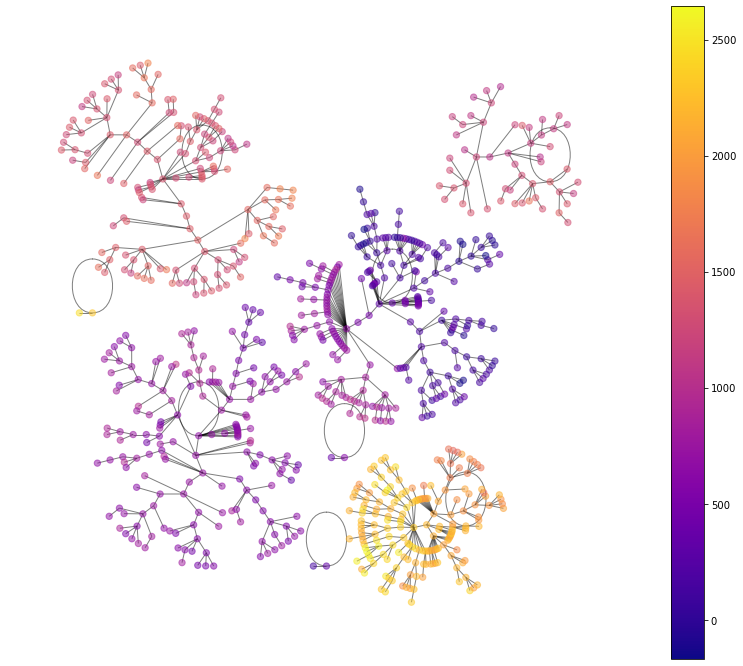

In [11]:
G = (population.ptree.drop_disconnected_roots()
               .ptree.to_networkx(node_col='trait'))

plot_tree(G, root=None, cmap=plt.cm.plasma);

We can also merge the forest shown above into a single tree using `pandas.DataFrame.ptree.merge_forest()`, which adds one new node and connects it to each of the tree root nodes.

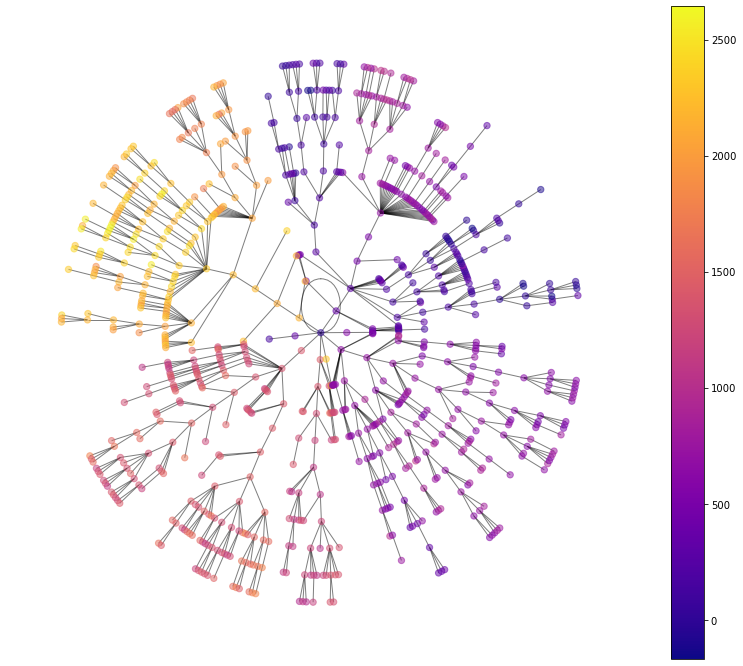

In [12]:
G2 = (population.ptree.drop_disconnected_roots()
                .ptree.merge_forest(-1, trait=0.)
                .ptree.to_networkx(node_col='trait'))

plot_tree(G2, root=-1, cmap=plt.cm.plasma);

## Simplify the tree or forest

The whole population history is drawn in the figure above. If we are only intersted in speciation events, it would make sense to first clean the tree(s) by merging all non-diverging branches (i.e., drop the nodes that have exactly one parent and one child and repair the connections between the other nodes). This is what the `pandas.DataFrame.ptree.simplify()` method does.

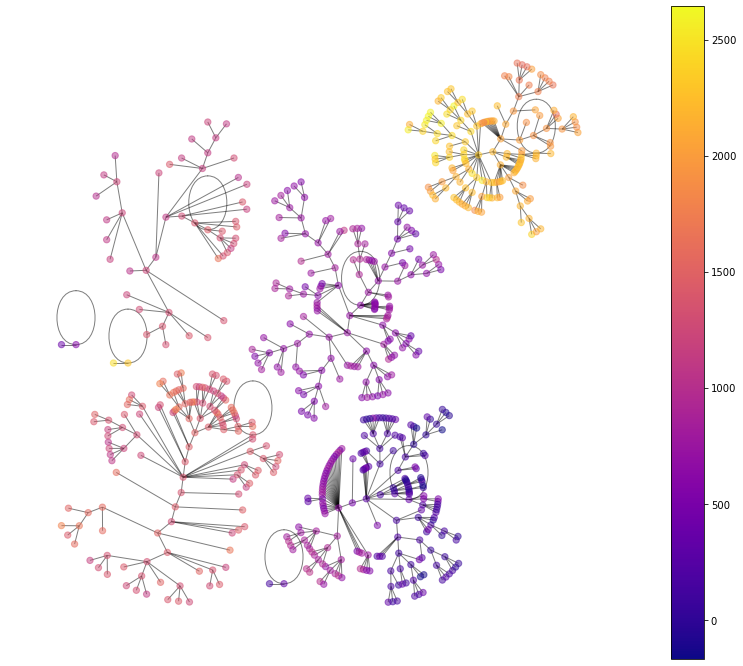

In [13]:
G3 = (population.ptree.drop_disconnected_roots()
                .ptree.simplify()
                .ptree.to_networkx(node_col='trait'))

plot_tree(G3, root=None, node_color='trait', cmap=plt.cm.plasma);

We can also draw the nodes according to their (x, y) positions to have an idea of the population dynamics within the landscape. In the figure below, the node grey gradient corresponds to steps and branches of the same color belong to the same tree.

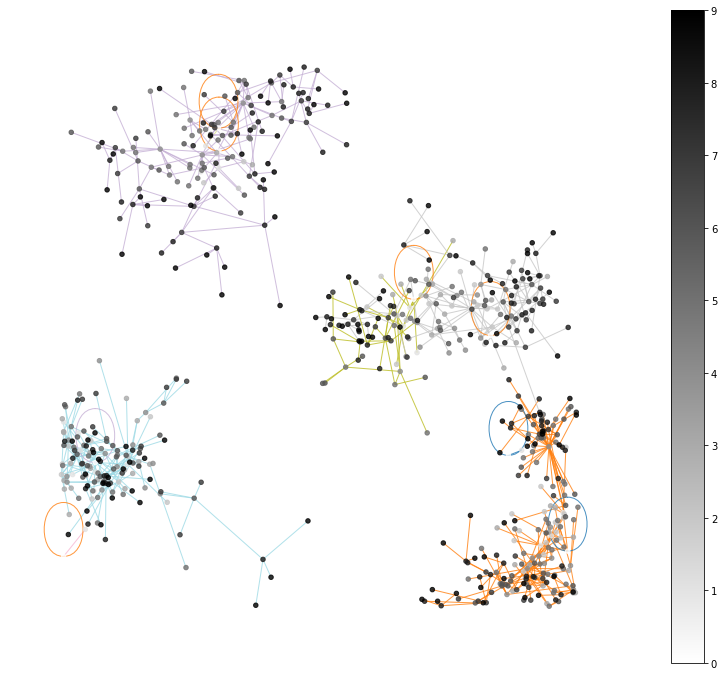

In [14]:
G4 = (population.ptree.drop_disconnected_roots()
                .assign(tree_id=population.ptree.tree_id)
                .ptree.simplify()
                .ptree.to_networkx(node_col=('x', 'y', 'step'),
                                   edge_col='tree_id'))

plot_tree(G4, pos=('x', 'y'), node_color='step', cmap=plt.cm.binary,
          edge_color='tree_id', edge_cmap=plt.cm.tab20,
          alpha=0.8, node_size=20);

Unfortunately, when drawing a single, simplified tree, the graphviz layout used doesn't allow jumping accross the concentric circles. Unlike the figure above, the steps are not aligned on the circles, which might be less convenient for the interpretation.

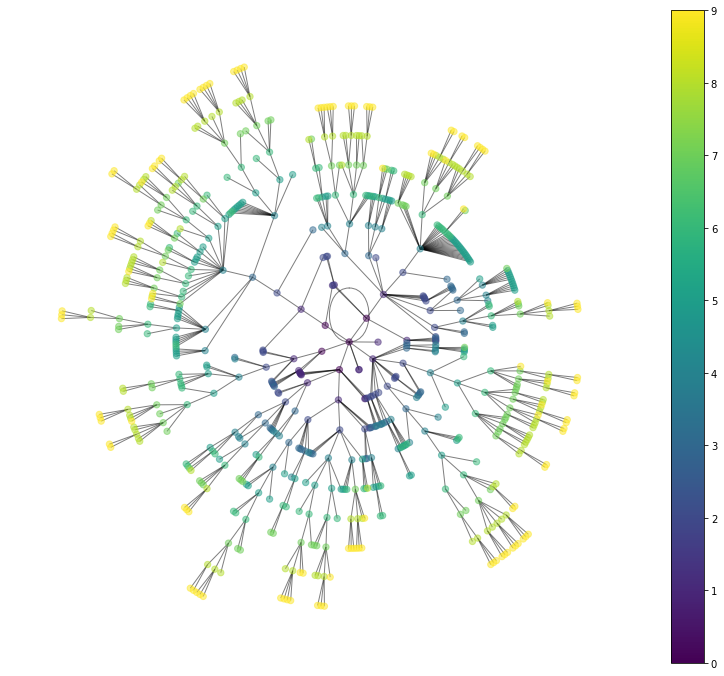

In [15]:
G5 = (population.ptree.drop_disconnected_roots()
                .ptree.merge_forest(-1, step=0)
                .ptree.simplify()
                .ptree.to_networkx(node_col='step'))

plot_tree(G5, root=-1, node_color='step', cmap=plt.cm.viridis);

## Extract Subtrees

It is also possible to explore only a subset of the original tree using with `pandas.DataFrame.ptree.extract_subtree()`, which propagates the selection up and/or down the hierarchical tree levels from new root and/or leaf nodes given as arguments.

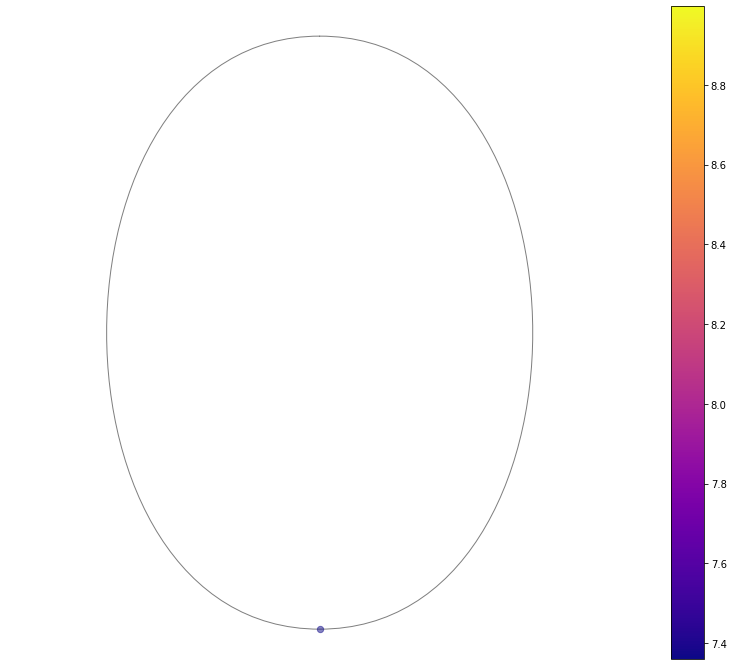

In [16]:
G6 = (population.ptree.extract_subtree(root=96)
                .ptree.simplify()
                .ptree.to_networkx(node_col='trait'))

plot_tree(G6, root=96, node_color='trait', cmap=plt.cm.plasma);

## Compatibility with other Python packages for phylogenic trees

The trees created here can easily be exported to various formats via the [phylopandas](https://github.com/Zsailer/phylopandas) package, so that they can be re-used with other tools. The example below shows how to export the extracted tree to the newick format. The `pandas.DataFrame.ptree.to_phylopandas()` method is used to slightly re-arrange the data frame so that it is compliant with phylopandas.  

In [14]:
newick_tree = (population.ptree.extract_subtree(root=96)
                         .ptree.to_phylopandas(length_from_col='time')
                         .phylo.to_newick())

newick_tree

'(154:5.0,((((555:5.0)432:5.0,((665:5.0,666:5.0,667:5.0)556:5.0,557:5.0)433:5.0,434:5.0)325:5.0,(((668:5.0,(((1044:5.0,1045:5.0)879:5.0,(1046:5.0,1047:5.0)880:5.0,(1048:5.0,1049:5.0)881:5.0,(1050:5.0)882:5.0,(1051:5.0)883:5.0,(1052:5.0)884:5.0,885:5.0,886:5.0,887:5.0,888:5.0,889:5.0,890:5.0)776:5.0,((1053:5.0,1054:5.0)891:5.0,892:5.0,(1055:5.0)893:5.0,894:5.0,895:5.0,896:5.0)777:5.0,(897:5.0,898:5.0,899:5.0,900:5.0)778:5.0)669:5.0)558:5.0,559:5.0,(670:5.0,671:5.0,672:5.0)560:5.0)435:5.0,436:5.0)326:5.0,327:5.0)240:5.0)155:5.0,156:5.0,((328:5.0)241:5.0,(329:5.0,330:5.0,331:5.0)242:5.0,(332:5.0)243:5.0,(((561:5.0)437:5.0)333:5.0,334:5.0,335:5.0)244:5.0,245:5.0,246:5.0,247:5.0)157:5.0)96:0.0;\n'